In [1]:
packages <- c(
  "tuneR",      # WAV file processing
  "fda.usc",    # Functional data processing
  "plot3D",     # For 3D plotting
  "mclust",     # For ARI
  "caret"       # For confusion matrix
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}
set.seed(42)

Warning message:
"package 'tuneR' was built under R version 4.3.3"
Warning message:
"package 'fda.usc' was built under R version 4.3.3"
Loading required package: fda

Warning message:
"package 'fda' was built under R version 4.3.3"
Loading required package: splines

Loading required package: fds

Warning message:
"package 'fds' was built under R version 4.3.3"
Loading required package: rainbow

Warning message:
"package 'rainbow' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: pcaPP

Warning message:
"package 'pcaPP' was built under R version 4.3.3"
Loading required package: RCurl

Warning message:
"package 'RCurl' was built under R version 4.3.3"
Loading required package: deSolve

Warning message:
"package 'deSolve' was built under R version 4.3.3"

Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-0. For overview t

### Prepare dataset filepaths

In [2]:
data_dir <- "SpeechCommands"
# When testing is TRUE, validation dataset is used for training
# When testing is FALSE, training dataset is used for training
testing <- TRUE

train_paths <- file.path(data_dir, readLines(file.path(data_dir, "train.txt")))
val_paths <- file.path(data_dir, readLines(file.path(data_dir, "val.txt")))
test_paths <- file.path(data_dir, readLines(file.path(data_dir, "test.txt")))

if (testing) {
  train_paths <- val_paths
}

sample_count <- data.frame(
  Subset = c("Train", "Validation", "Test"),
  Utterances = c(length(train_paths), length(val_paths), length(test_paths))
)

sample_count

Subset,Utterances
<chr>,<int>
Train,3338
Validation,3338
Test,3789


### Load training and testing sets
* Read signal from file
* Center signal
* Create log periodogram
* Interpolate onto a coarser grid
* Create fdata object

In [3]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 512)
  log_pgram <- approx(x = freqs, y = log_pgram, xout = reduced_freqs)$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

train <- load_dataset(train_paths)
test <- load_dataset(test_paths)

class_distribution <- data.frame(
  Class = levels(train$labels),
  Train = as.vector(table(train$labels)),
  Test = as.vector(table(test$labels))
)
cat("Class Distribution Summary\n")
print(class_distribution, row.names = FALSE)

Class Distribution Summary
 Class Train Test
  zero   352  385
   one   315  364
   two   316  384
 three   321  377
  four   347  368
  five   337  408
   six   348  374
 seven   351  376
 eight   318  376
  nine   333  377


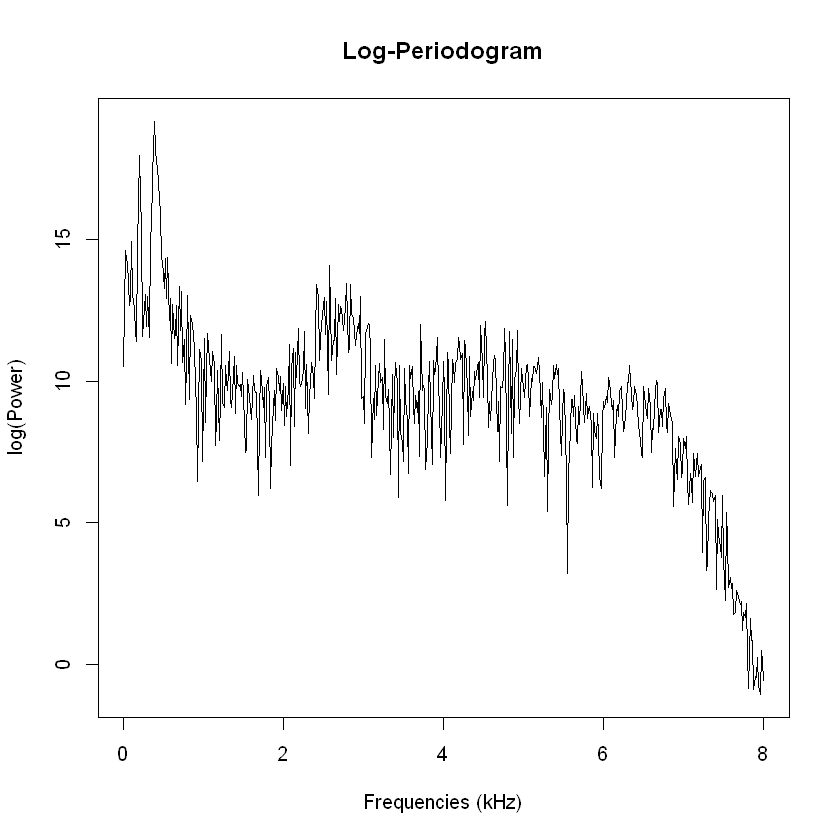

In [4]:
num_samples <- 1
plot(
  train$data[1:num_samples, ],
  main = "Log-Periodogram"
)

### Find optimal smoothing parames with Nadaraya-Watson

Optimal smoothing parameter: 0.03781162

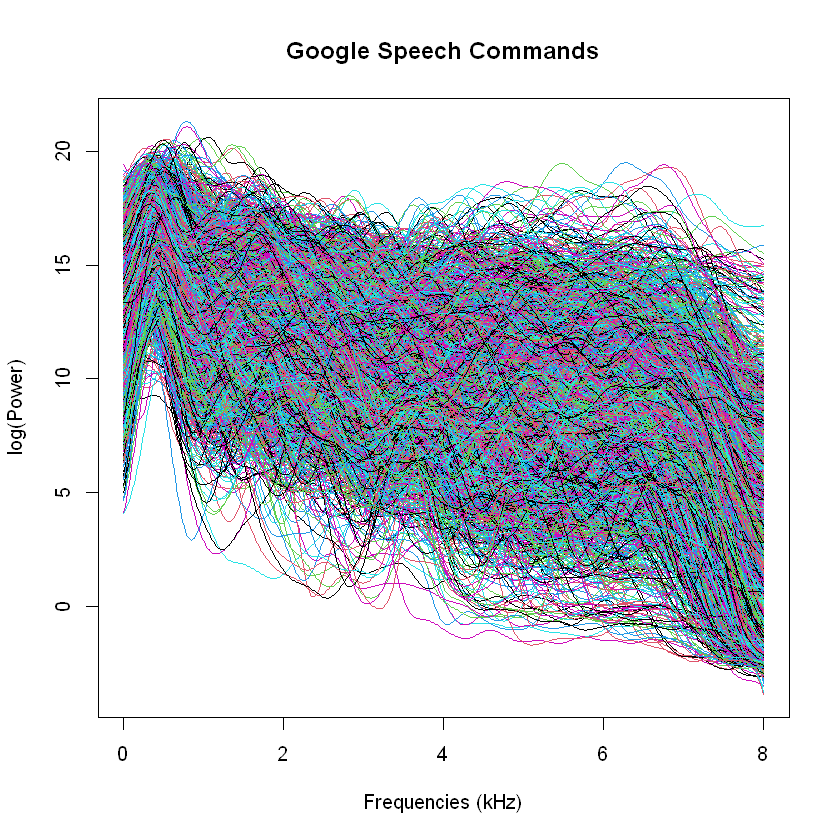

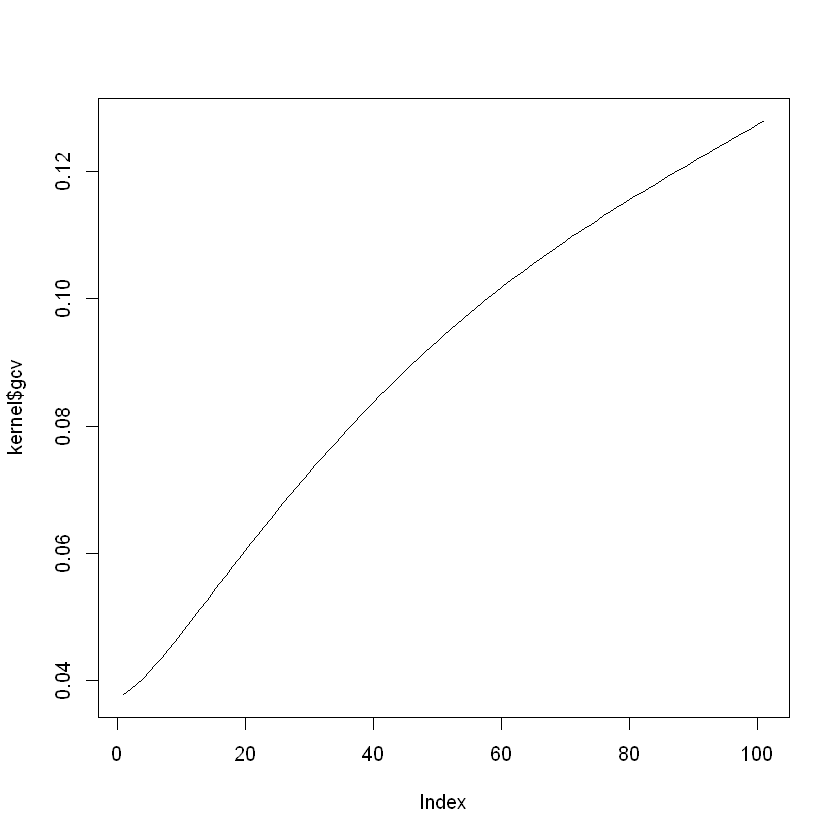

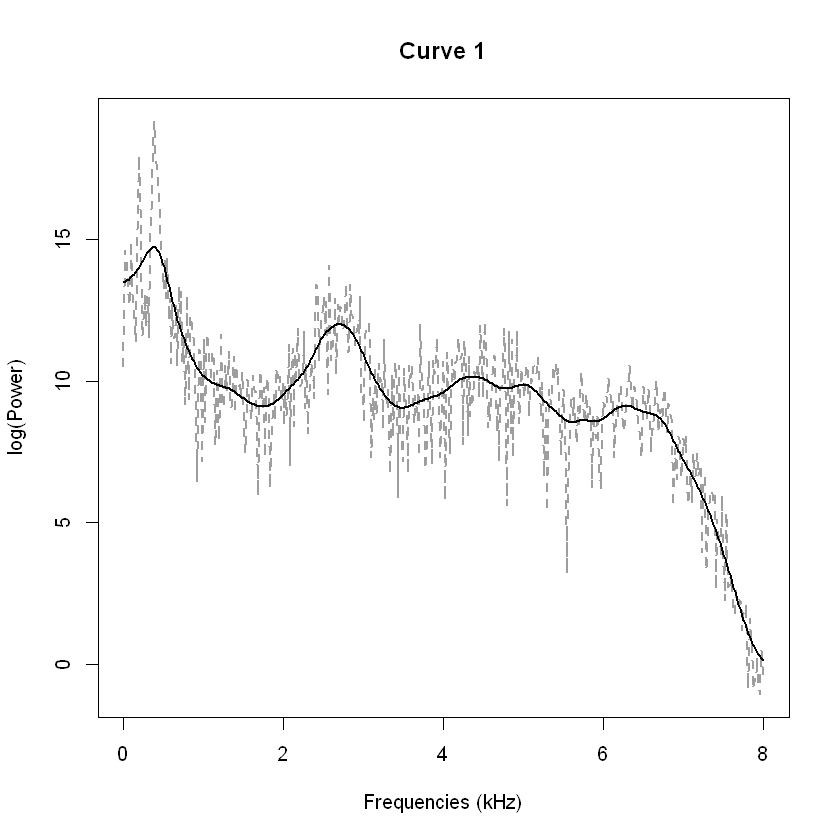

In [5]:
kernel <- fda.usc::optim.np(
  train$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
cat("Optimal smoothing parameter:", kernel$gcv.opt)

train$smooth <- kernel$fdata.est
plot(train$smooth)
plot(kernel$gcv, type = "l")

index <- 1
plot(
  train$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(train$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Apply smoothing to the test set

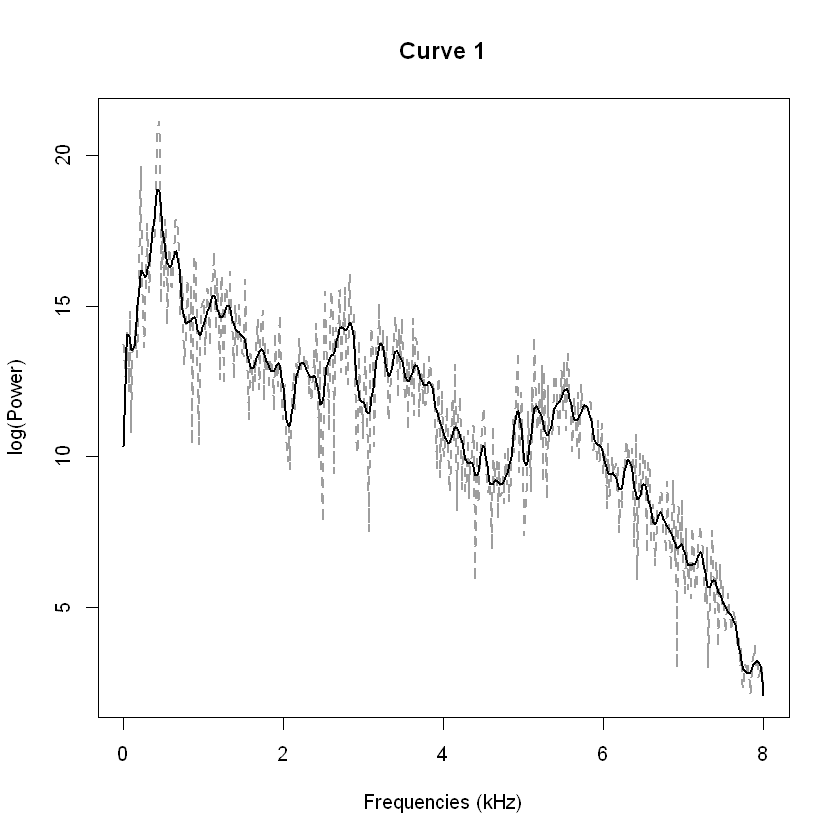

In [6]:
# Create smoothing matrix using the same grid as train data
# Apply the smoothing to the test data
s <- fda.usc::S.NW(test$data$argvals, h = kernel$gcv.opt)
smoothed_matrix <- test$data$data %*% s
test$smooth <- fda.usc::fdata(
  smoothed_matrix,
  argvals = test$data$argvals,
  rangeval = test$data$rangeval,
  names = test$data$names
)

index <- 1
plot(
  test$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(test$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Mean curve plots

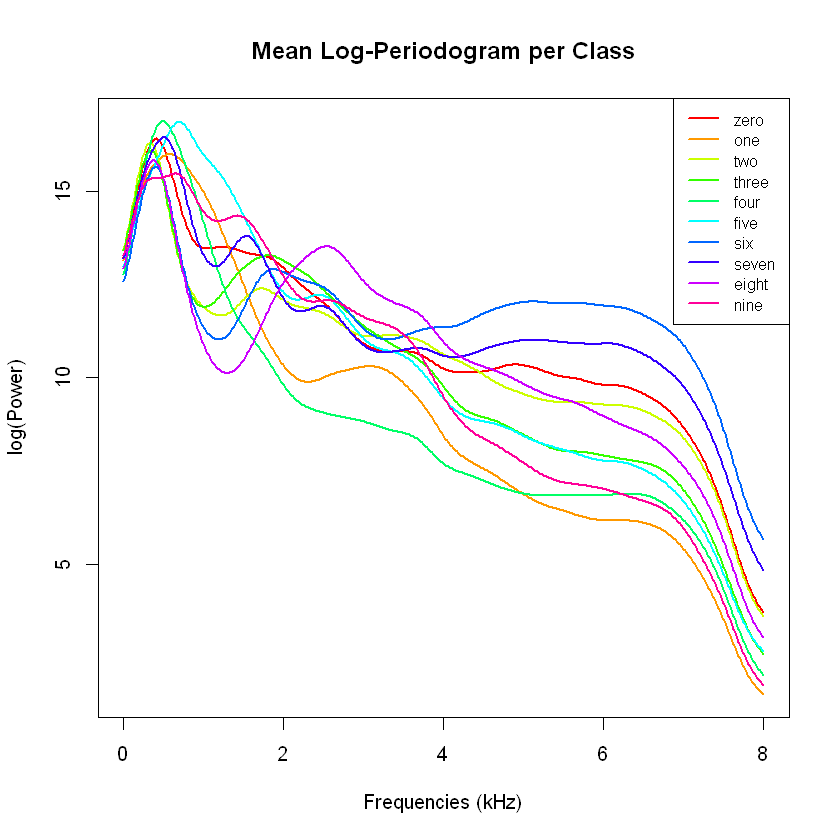

In [7]:
class_labels <- levels(train$labels)
num_classes <- length(class_labels)
palette <- rainbow(num_classes)

# Compute mean curves for each class
mean_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  func.mean(train$smooth[idx, ])
})

# Plot the first mean curve
plot(
  mean_curves[[1]],
  main = "Mean Log-Periodogram per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_curves, function(x) range(x$data)))
)

# Add the rest of the mean curves
for (i in 2:num_classes) {
  lines(mean_curves[[i]], col = palette[i], lwd = 2)
}

# Add legend
legend("topright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

### Derivative curve plots (velocity and accelaration)

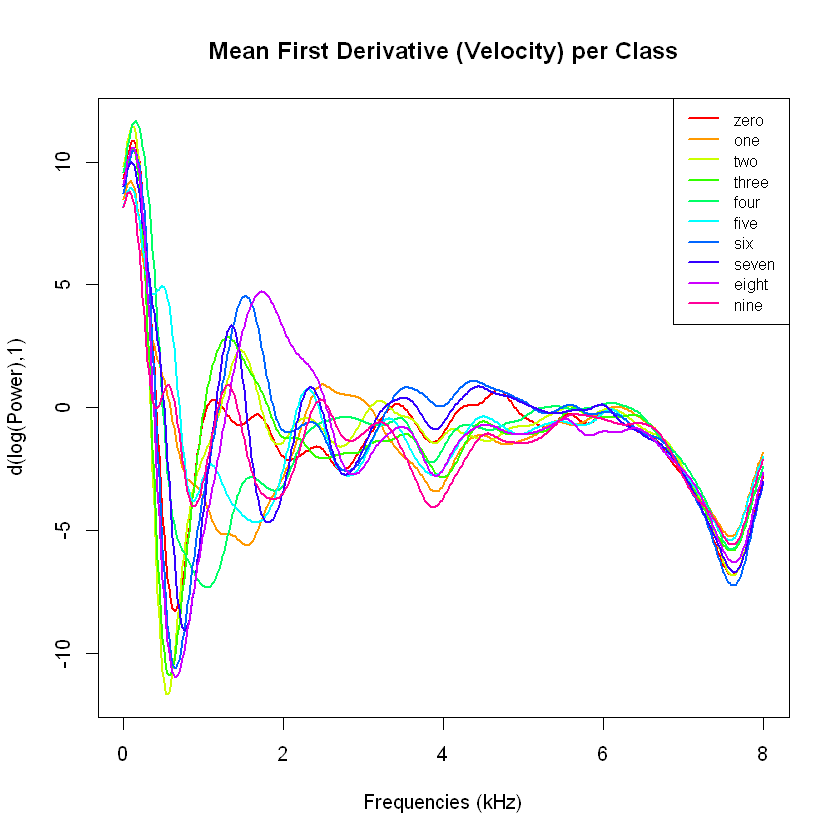

In [8]:
mean_deriv1_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv1 <- fdata.deriv(train$smooth[idx, ], nderiv = 1)
  func.mean(deriv1)
})

plot(
  mean_deriv1_curves[[1]],
  main = "Mean First Derivative (Velocity) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_deriv1_curves, function(x) range(x$data)))
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv1_curves[[i]], col = palette[i], lwd = 2)
}

legend("topright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

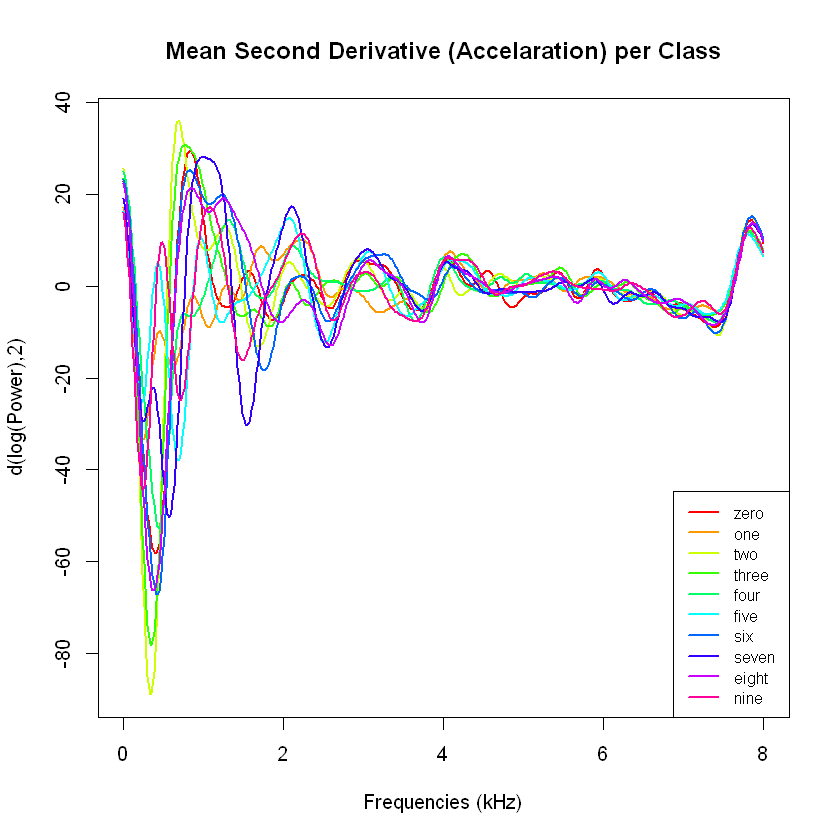

In [9]:
mean_deriv2_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv2 <- fdata.deriv(train$smooth[idx, ], nderiv = 2)
  func.mean(deriv2)
})

plot(
  mean_deriv2_curves[[1]],
  main = "Mean Second Derivative (Accelaration) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_deriv2_curves, function(x) range(x$data)))
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv2_curves[[i]], col = palette[i], lwd = 2)
}

legend("bottomright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

### Covariance plots

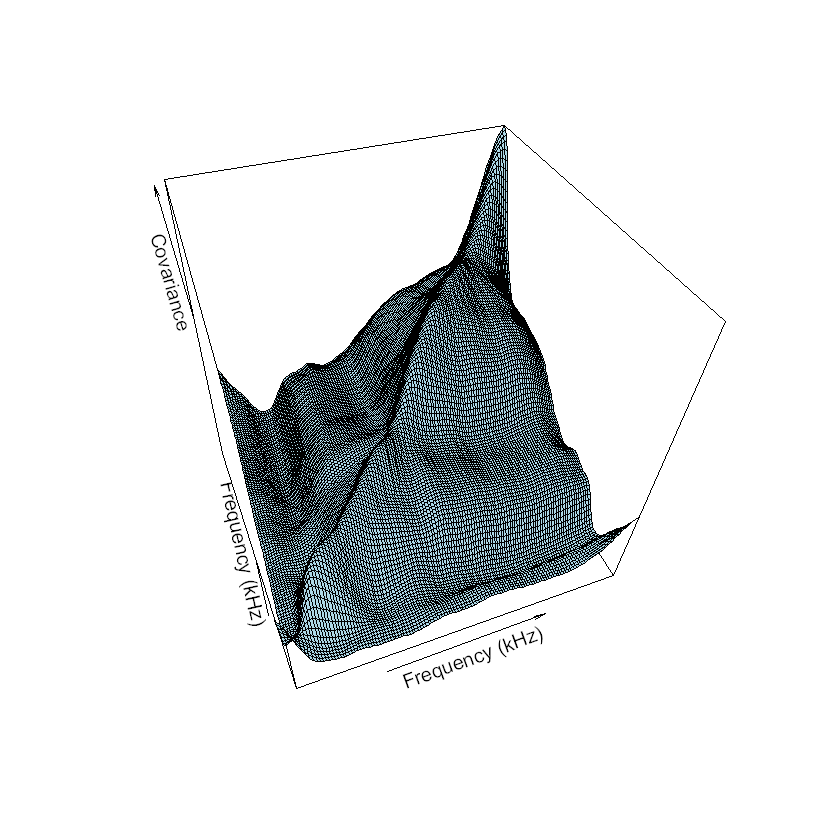

In [10]:
cov_matrix <- cov(train$smooth$data)
idx <- seq(1, ncol(cov_matrix), by = 4)
coarse_cov_matrix <- cov_matrix[idx, idx]
freqs <- train$smooth$argvals
freqs_coarse <- freqs[idx]

persp3D(
  x = freqs_coarse,
  y = freqs_coarse,
  z = coarse_cov_matrix,
  col = "lightblue", border = "black",
  xlab = "Frequency (kHz)",
  ylab = "Frequency (kHz)",
  zlab = "Covariance",
  phi = 45, theta = -20
)

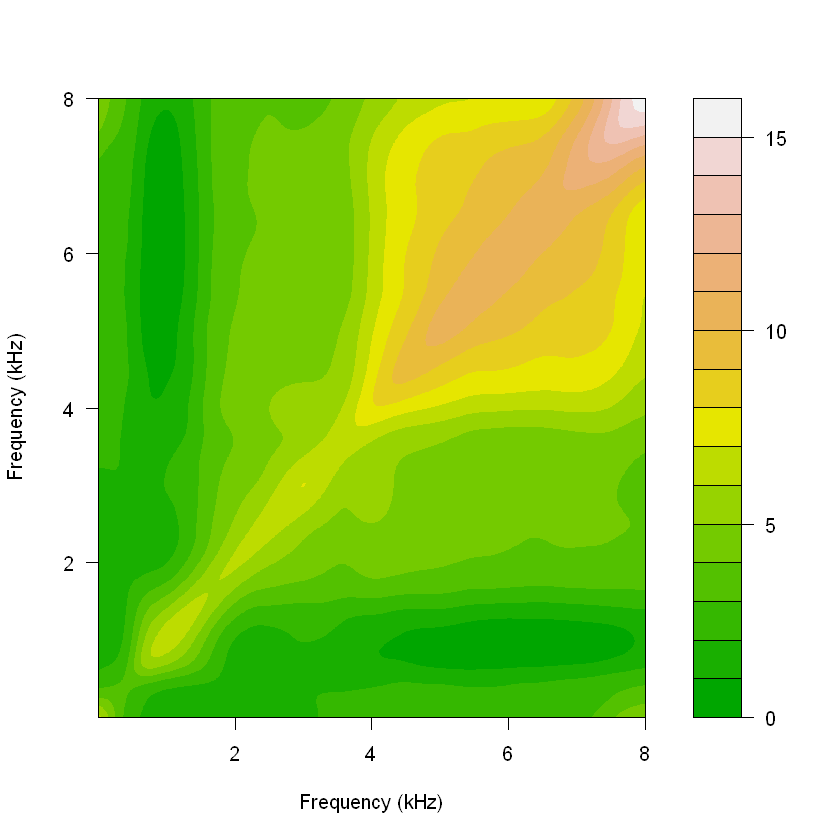

In [11]:
filled.contour(
  freqs, freqs, cov_matrix,
  color.palette = terrain.colors,
  ylab = "Frequency (kHz)",
  xlab = "Frequency (kHz)",
)

### K-means clustering

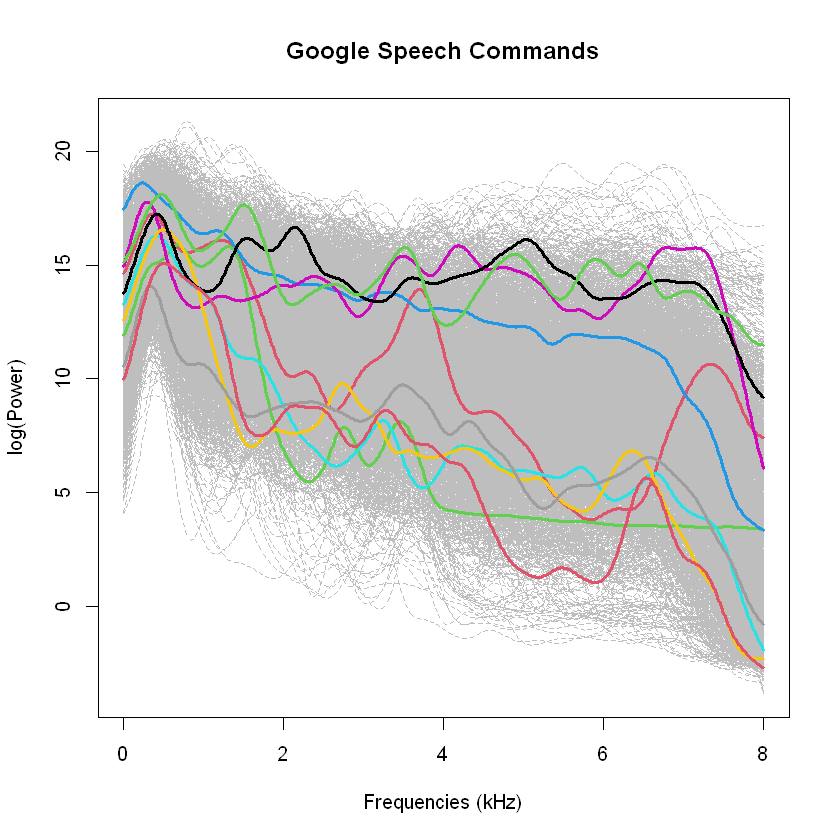

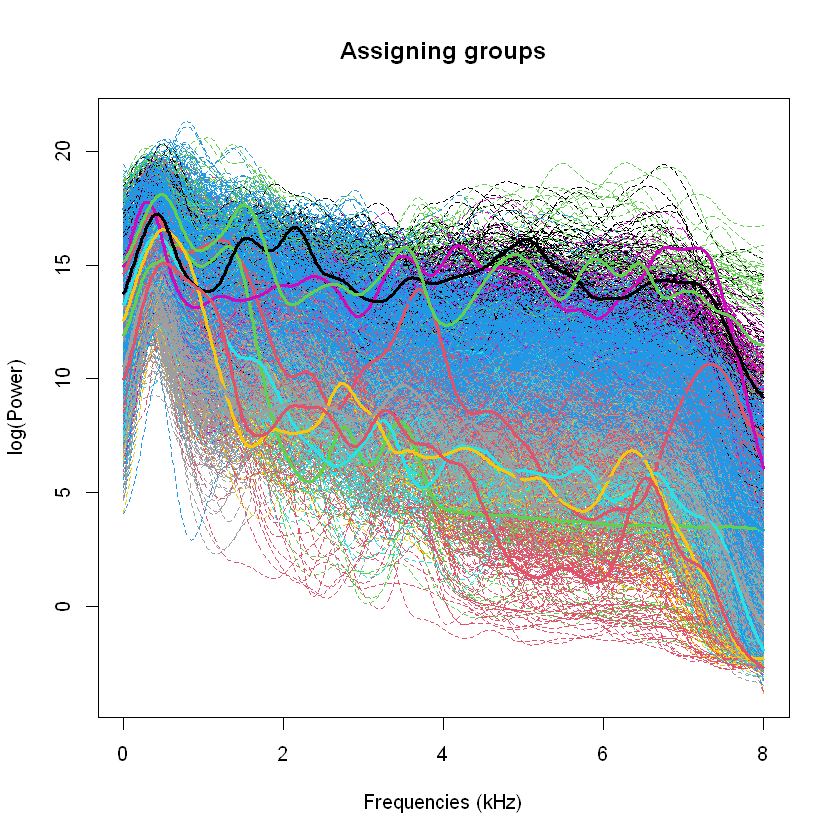

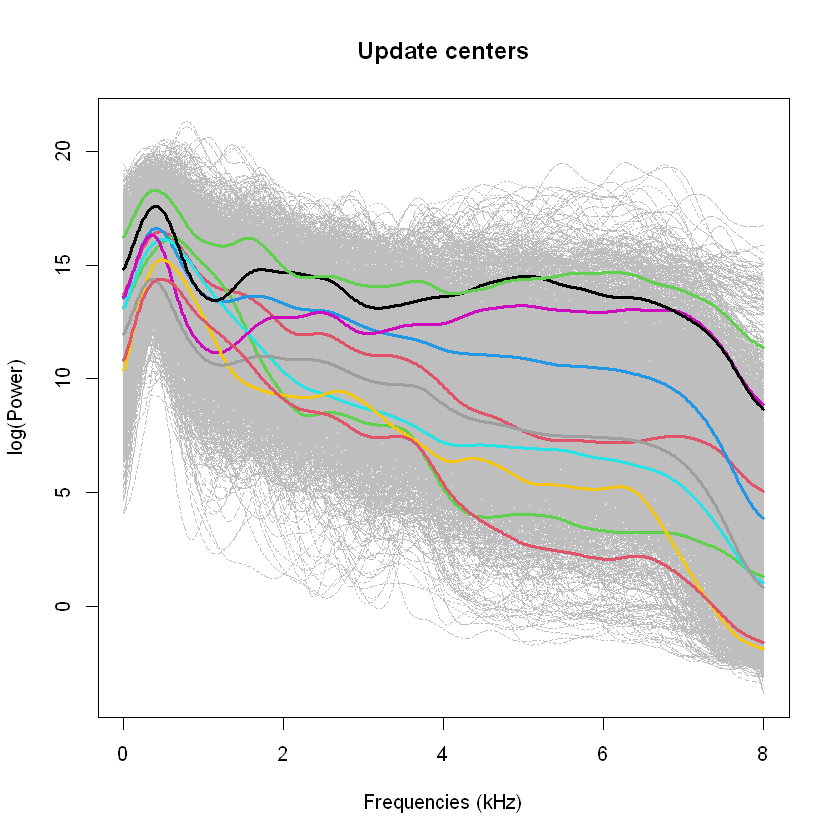

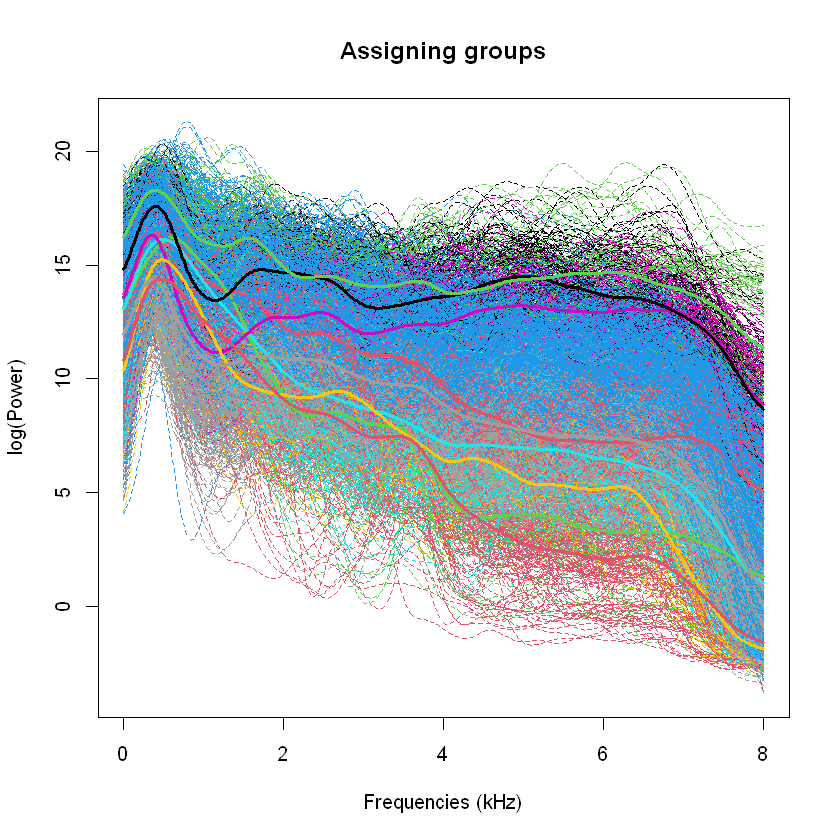

Cluster Sizes:

   1    2    3    4    5    6    7    8    9   10 
 389   60 1245  439  130   63  676  119  132   85 
Contingency Table (True Class vs Cluster):
       Cluster
True      1   2   3   4   5   6   7   8   9  10
  zero   30   3 204  16   8   3  65   9   5   9
  one    64  17  40 101   0  14  38   1  35   5
  two    31   1 136  18  23   3  88   5   7   4
  three  43   0 114  19   2   1 120   7  12   3
  four   50  19  48 143   1  17  37   1  26   5
  five   62  10 131  68   0   7  28   2  19  10
  six    10   0 157   1  71   1  52  48   2   6
  seven  27   1 165  19  12   8  50  33   2  34
  eight  13   0 142   0  13   5 125  12   4   4
  nine   59   9 108  54   0   4  73   1  20   5
Adjusted Rand Index (ARI): 0.0417


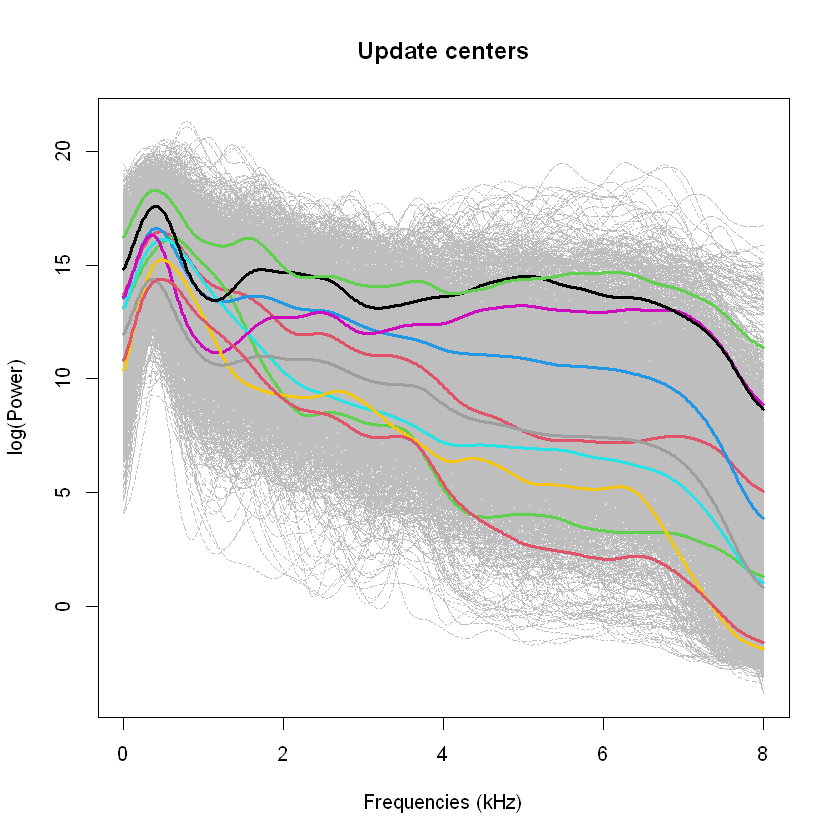

In [12]:
kmeans <- fda.usc::kmeans.fd(train$smooth, ncl = 10)
cat("Cluster Sizes:\n")
print(table(kmeans$cluster))

cat("Contingency Table (True Class vs Cluster):\n")
print(table(True = train$labels, Cluster = kmeans$cluster))

ari <- adjustedRandIndex(train$labels, kmeans$cluster)
cat(sprintf("Adjusted Rand Index (ARI): %.4f\n", ari))

### SVD

Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdrecon):
"Please assign column name for the data matrix."


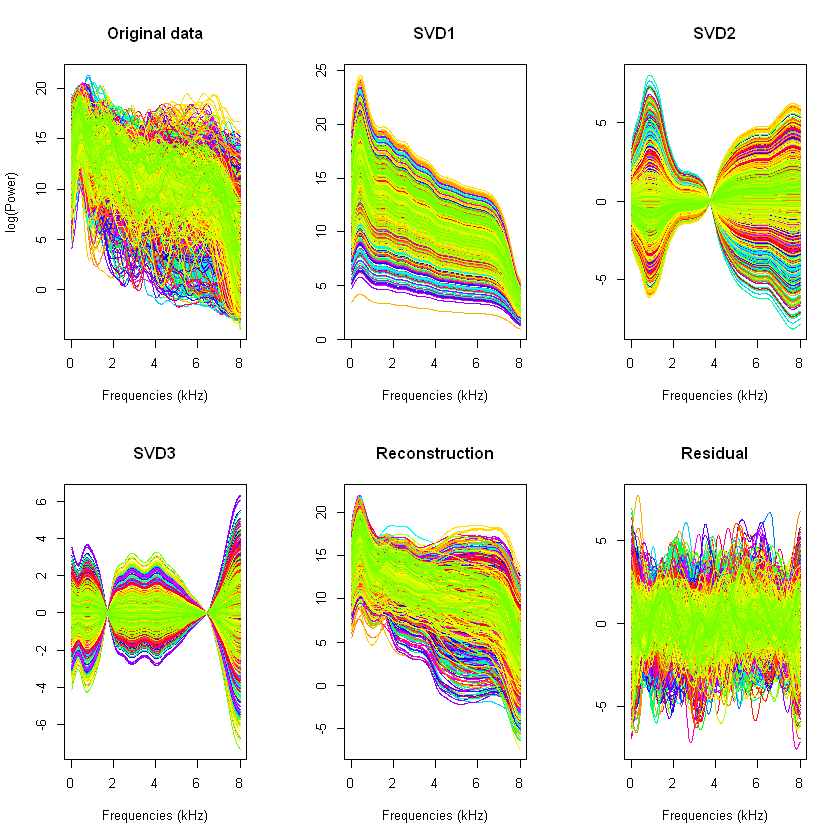

In [13]:
train$fds <- fds(
  x = train$smooth$argvals,
  y = t(train$smooth$data),
  xname = train$data$names$xlab,
  yname = train$data$names$ylab
)
SVDplot(train$fds, order = 3)

### fPCA

Number of PCs to explain at least 95% variance: 9 


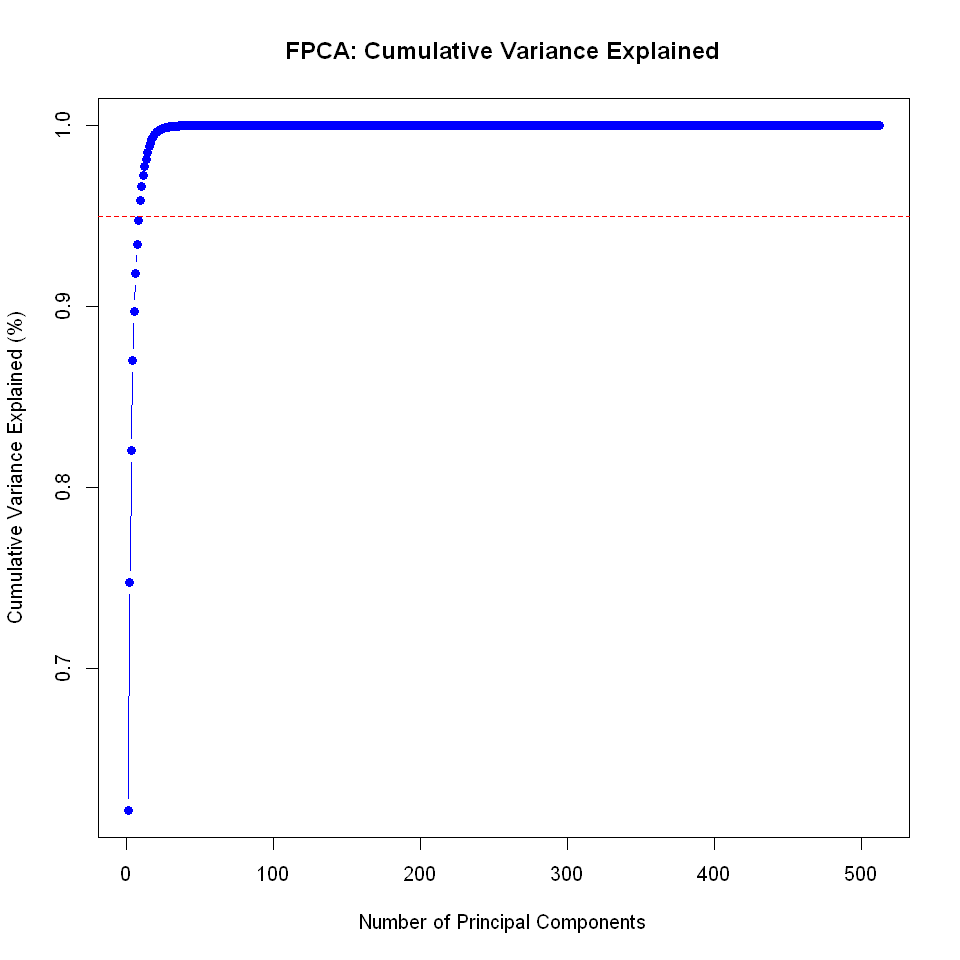

In [14]:
ncomp <- length(train$smooth$argvals)
fpca <- fdata2pc(train$smooth, ncomp = ncomp)

explained_var <- fpca$d^2 / sum(fpca$d^2)
cum_var <- cumsum(explained_var)

# Determine how many PCs explain at least 95%
top_n <- which(cum_var >= 0.95)[1]
cat("Number of PCs to explain at least 95% variance:", top_n, "\n")

options(repr.plot.width = 8, repr.plot.height = 8)
plot(
  cum_var, type = "b", pch = 19, col = "blue",
  xlab = "Number of Principal Components",
  ylab = "Cumulative Variance Explained (%)",
  main = "FPCA: Cumulative Variance Explained"
)

abline(h = 0.95, col = "red", lty = 2)

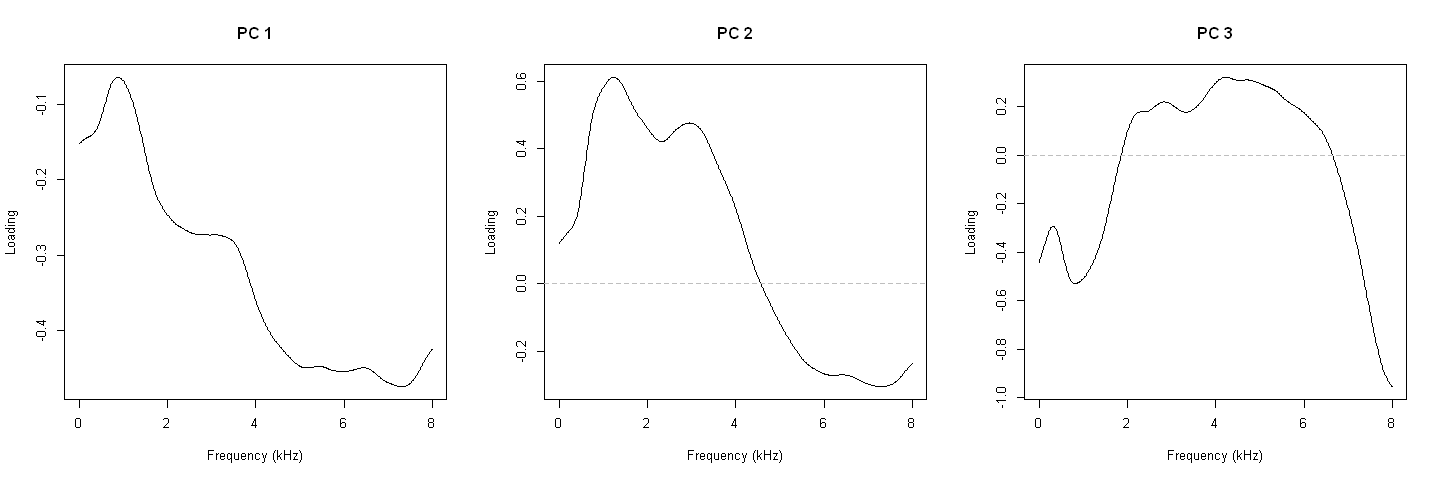

In [15]:
options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

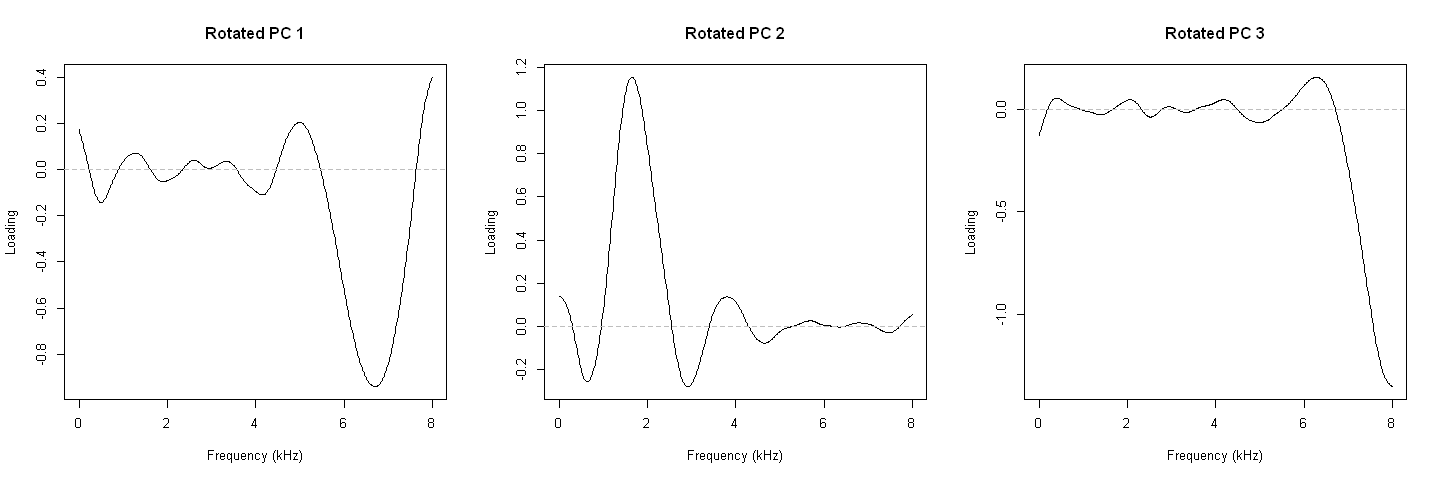

In [16]:
# Subset to top_n components
fpca$x <- fpca$x[, 1:top_n]
fpca$rotation$data <- fpca$rotation$data[1:top_n, ]

# Varimax rotation
rotated <- varimax(t(fpca$rotation$data))
fpca$rotation$data <- t(rotated$loadings)
fpca$x <- fpca$x %*% rotated$rotmat

options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("Rotated PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

PC1  explains: 62.17% variance
PC2  explains: 12.59% variance
PC3  explains:  7.31% variance
PC4  explains:  4.94% variance
PC5  explains:  2.72% variance
PC6  explains:  2.08% variance
PC7  explains:  1.65% variance
PC8  explains:  1.31% variance
PC9  explains:  1.10% variance


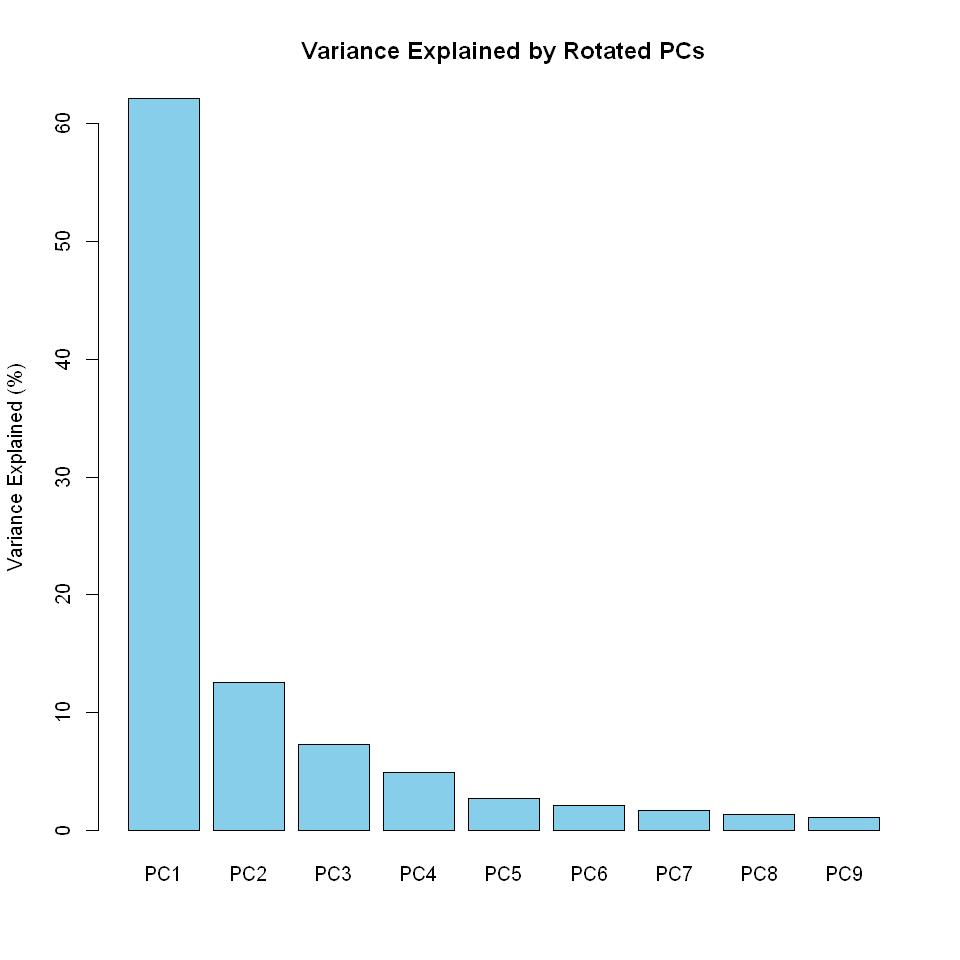

In [17]:
explained_var <- fpca$d^2 / sum(fpca$d^2)
explained_var_top <- explained_var[1:top_n]  # Only the rotated ones

for (i in 1:top_n) {
  cat(
    sprintf(
      "PC%-2d explains: %5.2f%% variance\n",
      i,
      explained_var_top[i] * 100
    )
  )
}

barplot(
  explained_var_top * 100,
  names.arg = paste0("PC", 1:top_n),
  ylab = "Variance Explained (%)",
  main = "Variance Explained by Rotated PCs",
  col = "skyblue"
)

### Classification
* Depth classifier
* GLM

In [18]:
depth_fit <- classif.depth(
  group = train$labels,
  fdataobj = train$smooth,
  newfdataobj = test$smooth,
  depth = "FM"
)

cm <- confusionMatrix(depth_fit$group.pred, test$labels)
print(cm)

class_stats <- cm$byClass

macro_f1     <- mean(class_stats[, "F1"])
macro_prec   <- mean(class_stats[, "Precision"])
macro_recall <- mean(class_stats[, "Recall"])

cat(sprintf("Macro Precision: %.3f\n", macro_prec))
cat(sprintf("Macro Recall:    %.3f\n", macro_recall))
cat(sprintf("Macro F1-score:  %.3f\n", macro_f1))

cat("\nPer-class metrics:\n")
print(class_stats[, c("Precision", "Recall", "F1")])

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    52   7  21    28   17   46  12    20     8   21
     one     10 112  30    42   45   43   2     5    40   67
     two     27   8  71    31   22   12  32    25    33    1
     three   20   4  37    81    3    4   3    13    23   16
     four    47  90  50    51  178   62  12    40    24   50
     five    19  91  12     3   26   99   1     9     4   73
     six     87   5  78    39   17   24 221   119    68   15
     seven  102  19  47    36   47   63  61   128    31   29
     eight   17  15  30    51   10   35  29    14   136   33
     nine     4  13   8    15    3   20   1     3     9   72

Overall Statistics
                                          
               Accuracy : 0.3035          
                 95% CI : (0.2889, 0.3184)
    No Information Rate : 0.1077          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [19]:
train_data_glm <- ldata(
  "df" = data.frame(y = train$labels),
  "x"  = train$smooth
)
test_data_glm <- list("x" = test$smooth)

glm_fit <- classif.glm(
  # formula: y is the response, x is the functional covariate
  y ~ x,
  data = train_data_glm,
  family = binomial(),  # multinomial families are handled automatically
  type = "1vsall"       # multiclass
)

glm_pred <- predict(glm_fit, test_data_glm)

cm <- confusionMatrix(glm_pred, test$labels)
print(cm)

class_stats <- cm$byClass

macro_f1     <- mean(class_stats[, "F1"])
macro_prec   <- mean(class_stats[, "Precision"])
macro_recall <- mean(class_stats[, "Recall"])

cat(sprintf("Macro Precision: %.3f\n", macro_prec))
cat(sprintf("Macro Recall:    %.3f\n", macro_recall))
cat(sprintf("Macro F1-score:  %.3f\n", macro_f1))

cat("\nPer-class metrics:\n")
print(class_stats[, c("Precision", "Recall", "F1")])

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    53  13  21    28    9   14  11    38    15   33
     one      2 111  19     3   22   40   0     6     2   30
     two     34   4  83    43   16    4  29    22    41    7
     three   40   5  48   141    7   11  28    19    69   52
     four    35  82  38     8  239   62   2    44     3   27
     five    39  75   3     5   41  200   0    14     0   53
     six     40   1  49    23    4    1 237    44    24    2
     seven   96   6  27     5   16   23  39   169     4    7
     eight   27   0  74    74    1    0  22     3   210    8
     nine    19  67  22    47   13   53   6    17     8  158

Overall Statistics
                                          
               Accuracy : 0.4225          
                 95% CI : (0.4067, 0.4385)
    No Information Rate : 0.1077          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         